# 🏞 Convolutional Neural Network

In this notebook, we'll walk through the steps required to train your own convolutional neural network (CNN) on the CIFAR dataset

In [1]:
import numpy as np

from tensorflow.keras import layers, models, optimizers, utils, datasets

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display

2023-07-07 18:41:11.366683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 18:41:11.473458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-07 18:41:11.473474: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-07 18:41:11.488445: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-07 18:41:11.874768: W tensorflow/stream_executor/platform/de

/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [2]:
NUM_CLASSES = 10

## 1. Prepare the Data <a name="prepare"></a>

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [4]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

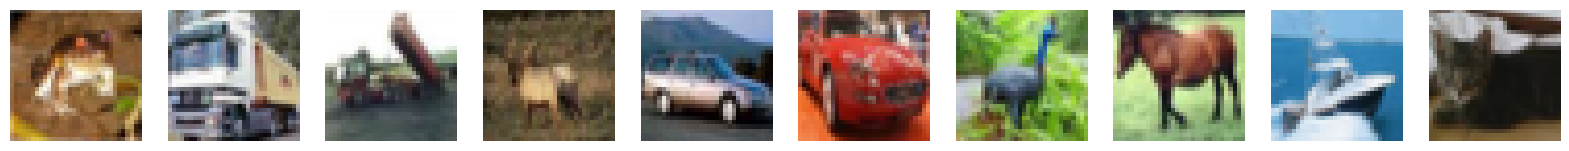

x_train shape: (50000, 32, 32, 3)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
y_train shape: (50000, 10)


In [5]:
display(x_train[:10])
print(f'x_train shape: {x_train.shape}')
print(y_train[:10])
print(f'y_train shape: {y_train.shape}')

## 2. Build the model <a name="build"></a>

## Mathamtical Overview

In the notebook convolutions.ipynb, we discuss the convolution operator. Here, however, we will add *Batch Normalization* and *Pooling*.

Consider the output of some layer $\mathbf{z} = g(W\mathbf{u} + \mathbf{b})$. Now, we apply batch normalization and get $\mathbf{z} = g(BN(W\mathbf{u}))$, where $BN$, during training, is:
$$ BN(\mathbf{x}, \gamma, \beta, \mathbf{x}_1, \ldots, \mathbf{x}_m) =
 \gamma \odot \frac{\mathbf{x-\mu(\mathbf{x}_1, \ldots, \mathbf{x}_m)}}{\sqrt{\sigma^2(\mathbf{x}_1, \ldots, \mathbf{x}_m) + \epsilon}} + \beta$$
 
Where $\mathbf{x} \in \{\mathbf{x}_1, \ldots, \mathbf{x}_m\}$, $\mathbf{x}_i, \gamma, \beta, \mu, \sigma, \epsilon \in \mathbb{R}^d$ and $\mu, \sigma$ are calculated as normal.
 
During inference, $BN$ is:

$$ BN(\mathbf{x}, \mathbf{y}, \beta) = \gamma \odot \frac{\mathbf{x}-\mu}{\sqrt{\sigma^2 + \epsilon}} + \beta $$
$$ \mu = \mathbb{E}_{\mathbf{x}_1, \ldots, \mathbf{x}_m} [\mu(\mathbf{x}_1, \ldots, \mathbf{x}_m)] $$
$$ \sigma^2 = \frac{m}{m-1}\mathbb{E}_{\mathbf{x}_1, \ldots, \mathbf{x}_m} [\sigma^2(\mathbf{x}_1, \ldots, \mathbf{x}_m)] $$

Note that $\gamma$ and $\beta$ are learned during training. All operations are element-wise and the gradients flow through $\sigma$ and $\mu$. During training, we keep a running average of our average and standard deviation to use in inference.
This helps the network avoid *Covariate Shift*, or the layers becoming too divergent during training.

Pooling simply reduces the output feature map further. We have *Max* and *Average* pooling:

$$ O_{i,j,k} = max_{m \in \{1,...,M\},n \in \{1,...,N\}} I_{si+m-1, sj+n-1, k} $$
$$ O_{i,j,k} = \frac{1}{MN} \sum_{m=1}^M \sum_{n=1}^N I_{si+m-1, sj+n-1, k} $$

*Dropout*, a form of regularization, turns off some of the neurons during training so that the neural network cannot as easily memorize the data. It is written (with $*^{(l)}$ signifying the layer):

$$ r^{(l)}_j \sim Bernoulli(p) $$
$$ \tilde{\mathbf{y}}^{(l)} = \mathbf{r}^{(l)} * \mathbf{y}^{(l)} $$
$$ z_i^{l+1} = \mathbf{w}_i^{l+1} \tilde{\mathbf{y}}^l + b_i^{l+1} $$
$$ y_i ^{l+1} = g(z_i^{l+1}) $$

We see that we have turned off some of the neurons and they will not contribute in the next layer. This looks like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/Dropout.png' alt='Dropout' width='750'>
</div>

Putting it all together, our CNN looks like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/CNN.png' alt='CNN' width='750'>
</div>

In [7]:
input_layer = layers.Input((32, 32, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")( # 2D Convolution with kernel size 3, strides of 1, and same padding
    input_layer
)
x = layers.BatchNormalization()(x) # Batch Normalization
x = layers.LeakyReLU()(x) # Activation Function

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x) # Flattening the output of all the conv layers

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x) # Dropout to prevent overfitting

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                             

2023-07-05 14:28:38.877594: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-05 14:28:38.877622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: OPH-M-DF98PS3L
2023-07-05 14:28:38.877626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: OPH-M-DF98PS3L
2023-07-05 14:28:38.877758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-07-05 14:28:38.877774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-07-05 14:28:38.877777: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.105.17 does not match DSO version 525.125.6 -- cannot find working devices in this configuration
2023-07-05 14:28:38.878106: I tensorflow/core/platform/cpu_feature_guard.cc:19

## 3. Train the model <a name="train"></a>

In [8]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [9]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, y_test),
)

Epoch 1/10


2023-07-05 14:28:43.025077: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


1562/1563 [============================>.] - ETA: 0s - loss: 1.5693 - accuracy: 0.4504

2023-07-05 14:29:07.499935: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


1563/1563 [==============================] - 25s 16ms/step - loss: 1.5691 - accuracy: 0.4504 - val_loss: 1.3598 - val_accuracy: 0.5054
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1508 - accuracy: 0.5947 - val_loss: 1.0317 - val_accuracy: 0.6379
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0017 - accuracy: 0.6506 - val_loss: 0.9747 - val_accuracy: 0.6531
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.9213 - accuracy: 0.6792 - val_loss: 0.9362 - val_accuracy: 0.6660
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8544 - accuracy: 0.7020 - val_loss: 0.9288 - val_accuracy: 0.6799
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.8026 - accuracy: 0.7221 - val_loss: 0.8737 - val_accuracy: 0.6950
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.7573 - accuracy: 0.7344 - val_loss: 0.9189 - val_accura

## 4. Evaluation <a name="evaluate"></a>

In [10]:
model.evaluate(x_test, y_test, batch_size=1000)

2023-07-05 14:37:23.591380: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.
2023-07-05 14:37:23.837012: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 131072000 exceeds 10% of free system memory.
2023-07-05 14:37:23.863427: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 131072000 exceeds 10% of free system memory.


10/10 [==============================] - 1s 128ms/step - loss: 0.7843 - accuracy: 0.7403


[0.7843415141105652, 0.7402999997138977]

In [11]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 [==============================] - 2s 5ms/step


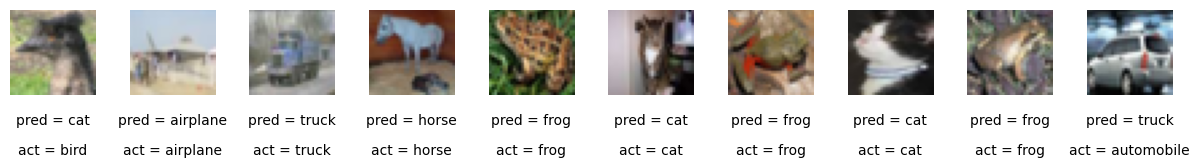

In [12]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)